# Part 0: Introduction Bayesian Inference

The main distinguishing characteristic of Bayesian inference is its ability to incorporate information that is not captured in observed data in a statistically valid way:

This concept is known as including a **prior** that is intended to reflect a belief about an outcome variable *before seeing any data*. This could come in the form of expert opinions, past research, gut feeling, business context, etc. Consequently, this prior is combined with the observational data

The prior values should be specified before commencing analysis. Then, as more empirical evidence is observed we combine the two information sources to produce and apply our inference on what is known as a **posterior**.

$$
Posterior = Prior \times \text{Observed evidence}
$$



In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats
import random
from datetime import datetime

# Set the style & colors for the plots
sns.set_style('darkgrid')
_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Control randomness for reproducibility
random.seed(1)

---
# Part 1: Data Generating Process


In this A/B test example, the VOI is ```conversion_rate```, a commonly relevant (binary) variable that we can simulate by sampling from a **Bernoulli distribution**. The treatment effect can be simulated by changing the mean of the control/treatment group.

User Input:
- ``n`` = Sample sizes
- ``true_prob`` = True conversion probability (with optional treatment effect)

Output:
- Two dictionaries: ```C``` (control), ```T``` (Treatment)
  - ``n`` = Sample size
  - ``true_prob`` = conversion rate of true DGP
  - ``sample`` = conversion outcomes
  - ``converted`` = total number of conversions = sum(sample)
  - ``sample_conversion_rate`` = conversion rate of sample

In [17]:
# Define Control & Treatment DGP (Bernoulli distributed)
C = {"n": 100000, "true_prob": 0.5}
T = {"n": 100000, "true_prob": 0.55}

In [18]:
def get_bernoulli_sample(mean, n):
    # Sample bernoulli distribution with relevant metrics
    samples = [1 if random.random() < mean else 0 for _ in range(n)]
    converted = sum(samples)
    mean = converted/n

    return samples, converted, mean

C["sample"], C["converted"], C["sample_conversion_rate"] = get_bernoulli_sample(mean = C["true_prob"], n = C["n"])
T["sample"], T["converted"], T["sample_conversion_rate"] = get_bernoulli_sample(mean = T["true_prob"], n = T["n"])

# visualise data structure
print(f"Control: {C['sample'][:10]}, Sample Conversion_Rate = {C['sample_conversion_rate']} (true = {C['true_prob']}) \nTreatment: {T['sample'][:10]}, Sample Conversion_Rate = {T['sample_conversion_rate']} (true = {T['true_prob']})")
print(f"\nsimulated treatment effect = {round((T['true_prob'] - C['true_prob'])*100, 2)}%")

Control: [1, 1, 0, 0, 1, 1, 0, 0, 0, 0], Sample Conversion_Rate = 0.4979 (true = 0.5) 
Treatment: [0, 0, 1, 1, 0, 1, 1, 1, 0, 1], Sample Conversion_Rate = 0.52853 (true = 0.53)

simulated treatment effect = 3.0%


---
# Part 2: Prior specifications

When considering priors in Bayesian A/B testing, to understand (and control) their effect, it is important to recognise where exactly they are present.

The following section elaborates on 2 types of priors:
- Prior odds (Hypothesis prior)
- Marginal likelihood prior (Parameter prior)

## Prior 1: Prior odds

**Definition: prior beliefs about probability of hypothesis being true.**

$$
Posterior = \mathbf{Prior} \times BF
$$


$$
\frac{P(H_1| \text{Data})}{P(H_0| \text{Data})} = \frac{\mathbf{P(H_1)}}{\mathbf{P(H_0)}} \times \frac{P(\text{Data}| H_1)}{P(\text{Data}| H_0)}
$$

User input:
- ```prior_odds``` = relative odds of alternative/null hypothesis being true. For example, a *prior_odds = 2* reflect 2:1 odds in favor of $H_1$ and thus claiming a prior belief of $H_1$ having twice as much likelihood of being true when compared to the $H_0$.


In [19]:
# Define Prior odds
prior_odds = 1

## Prior 2: Marginal likelihood prior

**Definition: prior beliefs about DGP parameter distributions, conditional on a hypothesis being true**

In Bayesian A/B testing, observational evidence is captured in so-called **Bayes Factors (BF)**.

$$
Posterior = Prior \times \mathbf{BF}
$$

$$
\frac{P(H_1| \text{Data})}{P(H_0| \text{Data})} = \frac{P(H_1)}{P(H_0)} \times \frac{\mathbf{P(\text{Data}| H_1)}}{\mathbf{P(\text{Data}| H_0)}}
$$


A Bayes Factor is a ratio of **Marginal Likelihoods**, not to be mistaken for normal likelihoods. In short: a Likelihood quantifies how probable the observed data is for a specific parameter value, while marginal likelihood averages the data's probability over all plausible parameter values within a given model through integration.

$$
P(\text{Data}| H_0) = \int P(\text{Data}|\lambda, H_0) \mathbf{P(\lambda|H_0)} \, d\lambda
$$

In this context, the parameter $\lambda$ represents the conversion rate for the treatment/control group's (assumed) DGP, i.e. $data \sim Bernoulli(\lambda)$, over which we need to specify a prior as well. This affects how the averaging process in marginal likelihood is executed. In this context, the prior reflects the expected probability distribution of the conversion rate parameter for the bernoulli distribution behind the control/treatment data, thus a *prior belief on a DGP parameter distribution*.

The assumed distribution here is a **Beta-Binomial distribution**, a distribution that fits our purposes because:
- Only defined in range (0,1), just like our target variable ```conversion rate``` (probability)
- Marginal Likelihood computation convenience

see: https://medium.com/@ro.mo.flo47/the-beta-binomial-model-an-introduction-to-bayesian-statistics-154395875f93

User input:
- ```mean``` = prior belief on conversion rate
- ```weight``` = prior distribution variance, or practically speaking, the degree of certainty in prior belief (recommended to play around with multiple values while inspecting the prior visualisations).

In [ ]:
# Specify prior distribution (mean + "weight" as proxy for variance)
mean_C, weight_C = 0.5, 1000
mean_T, weight_T = 0.55, 1000

Helper function to abstract away, the transformation steps to get from tangible prior beliefs on effect magnitude (mean) & associated certainty (weight) to Beta distributions parameters.

Output:
- Two dictionaries ```C_prior``` (Control), ```T_prior``` (Treatment):
  - ```alpha``` = shape & location parameter, skews distribution to higher conversion rates ($\lambda$ = 1)
  - ```beta``` = shape & location parameter, skews distribution to lower conversion rates ($\lambda$ = 0)

In [ ]:
# Help function with determining alpha & beta
def beta_helper(prior_prob, weight):
    # Sample from Beta distribution: B(weight(prior belief) + 1, weight(1 - prior belief) + 1)
    a = round(prior_prob, 2) * weight + 1
    b = (1 - round(prior_prob, 2)) * weight + 1
    return round(a), round(b)

# parameters: Mean, weight
C_prior, T_prior = dict(), dict()
C_prior["alpha"], C_prior["beta"] = beta_helper(mean_C, weight_C)
T_prior["alpha"], T_prior["beta"] = beta_helper(mean_T, weight_T)

In [ ]:
# Visualisation function for beta distribution
def plot_beta_distribution(T_alpha, T_beta, T_mean, C_alpha, C_beta, C_mean):
    # Generate values between 0 and 1 (these are the possible values of a Beta distribution)
    x = np.linspace(0, 1, 1000)

    # Calculate the value of the pdf for each x value
    C_dist = stats.beta.pdf(x, C_alpha, C_beta)
    T_dist = stats.beta.pdf(x, T_alpha, T_beta)

    # Plot distributions & means
    plt.plot(x, C_dist, label=f'Control: α={C_alpha}, β={C_beta} (mean: {C_mean})', color = _colors[0])
    plt.axvline(C_mean, color = _colors[0], linestyle = "--", alpha = 0.5)

    plt.plot(x, T_dist, label=f'Treatment: α={T_alpha}, β={T_beta} (mean: {T_mean})', color = _colors[1])
    plt.axvline(T_mean, color = _colors[1], linestyle = "--", alpha = 0.5)

    plt.title('Prior conversion_rate Distributions (Beta-binomial)')
    plt.xlabel('Conversion rate')
    plt.ylabel('pdf(x)')
    plt.ylim(bottom=0)
    plt.legend()
    plt.grid(True)
    plt.show()

print("using helper function:")
plot_beta_distribution(T_prior["alpha"], T_prior["beta"], mean_T, C_prior["alpha"], C_prior["beta"], mean_C)

In [ ]:
# Visualisation function for beta distribution
def plot_beta_distribution(T_alpha, T_beta, T_mean, C_alpha, C_beta, C_mean):
    # Generate values between 0 and 1 (these are the possible values of a Beta distribution)
    x = np.linspace(0, 1, 1000)

    # Calculate the value of the pdf for each x value
    C_dist = stats.beta.pdf(x, C_alpha, C_beta)
    T_dist = stats.beta.pdf(x, T_alpha, T_beta)

    # Plot distributions & means
    plt.plot(x, C_dist, label=f'Control: α={C_alpha}, β={C_beta} (mean: {C_mean})', color = _colors[0])
    plt.axvline(C_mean, color = _colors[0], linestyle = "--", alpha = 0.5)

    plt.plot(x, T_dist, label=f'Treatment: α={T_alpha}, β={T_beta} (mean: {T_mean})', color = _colors[1])
    plt.axvline(T_mean, color = _colors[1], linestyle = "--", alpha = 0.5)

    plt.title('Beta Distribution')
    plt.xlabel('x')
    plt.ylabel('pdf(x)')
    plt.ylim(bottom=0)
    plt.legend()
    plt.grid(True)
    plt.show()

# Evidence evaluation
- Effect estimation
- Quantifying level of certainty

---
## Beta-Binomial Marginal Likelihood
define (per group):
- Observations:
  - n (sample size)
  - c (nr of conversions)
- Prior (conditional on Hypothesis?):
  - $\alpha$
  - $\beta$

Marginal likelihood:
$$P[data|H] = \binom{N}{C}\frac{Beta(\alpha + c, \beta + (n - c)}{Beta(\alpha, \beta)}$$

Likelihood:
$$L(p; \mathbf{x}) = \prod_{i=1}^{n} p^{x_i} (1-p)^{1-x_i} = p^c(1 - p)^{n - c}$$

Marginal Likelihood distribution (?):
$$Beta(\alpha + c, \beta + (n - c))$$

---
**Current challenge:**
What are the marginal likelihoods that should be divided & which parameters do we put in there?



we have 6 options:
1. Treatment + H0 prior (no effect)
2. Treatment + H1 prior (effect)
3. Control + H0 prior (no effect)
4. Control + H1 prior (effect)
5. Treatment + point estimate H0 prior (no effect)
6. Treatment + point estimate H1 prior (effect)
7. Control + point estimate H0 prior (no effect)
8. Control + point estimate H1 prior (effect)

Intuitively I'd think either:
- 2 / 1 -> only considers T, checks whether it's more likely to belong to effect DGP or not
- 1 / 3 -> conditions on no effect prior and weight T vs C (seems like frequentist?)
- 2 / 5 -> Distributions of priors most accurately depict hypothesis design

Sanity check:
- 4 / 3 should strong favor H0 in presence of treatment

old approach:
- 6 / 5 compare likelihoods of hypotheses (point) for treatment only




Different variations of ways to compute (marginal) likelihood for Beta-binomial distributions

In [ ]:
from math import comb
from scipy.special import beta as beta_function

import numpy as np
from scipy.special import gammaln

# Marginal likelihood (hypothesis: distribution)
def marginal_likelihood_1(prior_alpha, prior_beta, n, converted):
    # Beta distribution because prior Beta distribution is conjugate
    beta_posterior = stats.beta(prior_alpha + converted, prior_beta + (n - converted))
    samples = beta_posterior.rvs(size = 100_000)
    return samples

def marginal_likelihood_2(alpha, beta, n, converted):
    return comb(n, converted) * beta_function(converted + alpha, n - converted + beta) / beta_function(alpha, beta)

def marginal_likelihood_3(alpha, beta, n, converted): # via log (maybe necessary if n too large)
    # Log transformation of marginal likelihood function
    log_comb = gammaln(n+1) - gammaln(converted+1) - gammaln(n-converted+1)
    log_beta1 = gammaln(converted + alpha) + gammaln(n - converted + beta) - gammaln(n + alpha + beta)
    log_beta2 = gammaln(alpha) + gammaln(beta) - gammaln(alpha + beta)
    log_result = log_comb + log_beta1 - log_beta2
    return np.exp(log_result)


def bernoulli_likelihood(hypothesis_mean, converted, n):
    # Bernoulli likelihood (through log to avoid exploding values)
    log_conversions = converted * np.log(hypothesis_mean)
    log_non_conversions = (n - converted) * np.log(1 - hypothesis_mean)
    log_likelihood = log_conversions + log_non_conversions
    return log_likelihood


In [ ]:
# Input data
c1 = [C_prior["alpha"], C_prior["beta"], T["n"], T["converted"]] # T + H0 (C prior)
c2 = [T_prior["alpha"], T_prior["beta"], T["n"], T["converted"]] # T + H1 (T prior)
c3 = [C_prior["alpha"], C_prior["beta"], C["n"], C["converted"]] # C + H0 (C prior)
c4 = [T_prior["alpha"], T_prior["beta"], C["n"], C["converted"]] # C + H1 (T prior)

# Calculate BF
numerator = marginal_likelihood_3(*c2)
denominator = marginal_likelihood_3(*c1)
bayes_factor = numerator / denominator

print("BF:", round(bayes_factor, 3))

BF: 117.23


In [ ]:
# idea: https://chat.openai.com/share/6a6bbec6-cbd6-4a24-8289-29872da3ee03
from scipy.special import betaln

def compute_log_bayes_factor(alpha_0, beta_0, alpha_t, beta_t, alpha_c, beta_c, s_t, n_t, s_c, n_c):
    # Log probability of data under H0
    log_prob_data_H0 = betaln(alpha_0 + s_t + s_c, beta_0 + n_t + n_c - s_t - s_c) - betaln(alpha_0, beta_0)

    # Log probability of data under H1 for treatment group
    log_prob_data_H1_treatment = betaln(alpha_t + s_t, beta_t + n_t - s_t) - betaln(alpha_t, beta_t)

    # Log probability of data under H1 for control group
    log_prob_data_H1_control = betaln(alpha_c + s_c, beta_c + n_c - s_c) - betaln(alpha_c, beta_c)

    # Log joint probability of data under H1
    log_prob_data_H1 = log_prob_data_H1_treatment + log_prob_data_H1_control

    # Compute Log Bayes Factor
    log_BF_10 = log_prob_data_H1 - log_prob_data_H0
    bf_10 = np.exp(log_BF_10)

    return bf_10

# Example usage:
alpha_0, beta_0 = C_prior["alpha"], C_prior["beta"]
alpha_t, beta_t = T_prior["alpha"], T_prior["beta"]
alpha_c, beta_c = C_prior["alpha"], C_prior["beta"]
s_t, n_t = T["converted"], T["n"]  # Successes and total observations for treatment group
s_c, n_c = C["converted"], C["n"]  # Successes and total observations for control group

BF_10 = compute_log_bayes_factor(alpha_0, beta_0, alpha_t, beta_t, alpha_c, beta_c, s_t, n_t, s_c, n_c)
print(f"Bayes Factor (BF_10) = {BF_10}")


Bayes Factor (BF_10) = 1.6014438939676447e+102


In [ ]:
c5 = [mean_C, T["converted"], T["n"]] # T + prior H0
c6 = [mean_T, T["converted"], T["n"]] # T + prior H1
c7 = [mean_C, C["converted"], C["n"]] # C + prior H0
c8 = [mean_T, C["converted"], C["n"]] # C + prior H1

# Calculate BF
numerator_log_likelihood = bernoulli_likelihood(*c6)
denominator_log_likelihood = bernoulli_likelihood(*c5)
bayes_factor_old = np.exp(numerator_log_likelihood - denominator_log_likelihood)

print("\nBF (old & likely wrong):", round(bayes_factor_old, 3))


BF (old & likely wrong): 1.2542655510724853e+208


[501, 501, 100000, 54892] [551, 451, 100000, 54892]


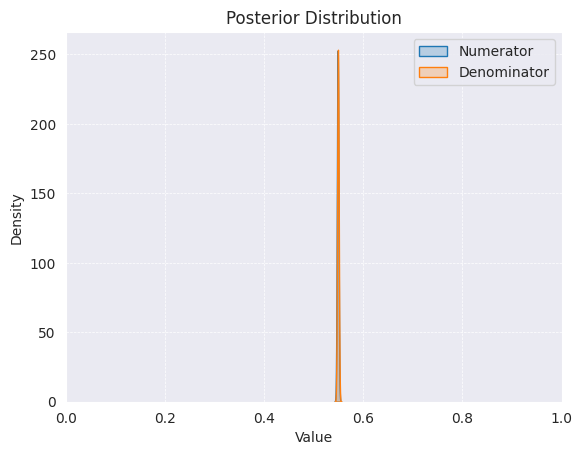

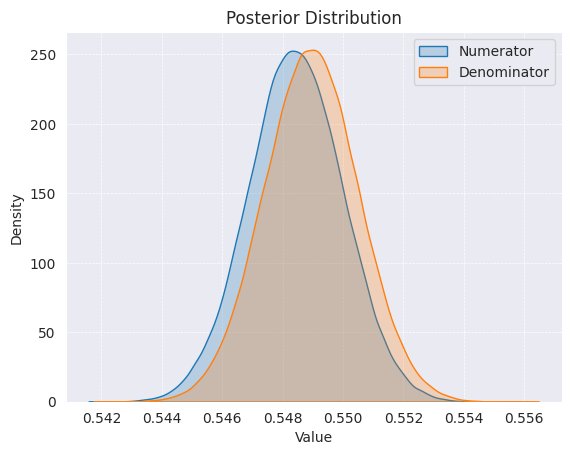

In [ ]:
# Generate the samples
samples_numerator = marginal_likelihood_1(*c1)
samples_denominator = marginal_likelihood_1(*c2)

print(c1, c2)

# Plotting the distribution of the samples
sns.kdeplot(samples_numerator, fill = True, label = "Numerator")
sns.kdeplot(samples_denominator, fill = True, label = "Denominator")
plt.xlabel("Value")
plt.ylabel("Density")
plt.xlim(0,1)
plt.title("Posterior Distribution")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

# Plotting the distribution of the samples
sns.kdeplot(samples_numerator, fill = True, label = "Numerator")
sns.kdeplot(samples_denominator, fill = True, label = "Denominator")
plt.xlabel("Value")
plt.ylabel("Density")
plt.title("Posterior Distribution")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

In [ ]:
post_odds = prior_odds * bayes_factor
